# Compute FSS

Notebook to compute Fraction skill score (FSS) for both case studies
- Code at https://zenodo.org/records/10518328 contains Python3 and Fortran90 modules/subroutines to calculate the deterministic and probabilistic FSS

## Import libraries

In [1]:
# Basic libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
import os

# Fraction skill score libraries from https://zenodo.org/records/10518328
from __future__ import division        
from compute_FSS import fss_prob, fss_det
from fss90 import mod_fss
import compare_fss_flavors as cff


In [2]:
schemes = ['Thompson', 'Morrison', 'CAM', 'Ylin', 'WDM7', 'WDM6']


## Prepare MCS

### Open datasets

Define paths

In [3]:
obs_path = '/media/irene/Elements/Laptop_dec2023/Thesis_data/obs/'
sim_path = '/media/irene/Elements/wrf_micro/'


Open datasets

In [4]:
# Observations and reanalysis 
ds_ERA = xr.open_dataset(f'{obs_path}/ERA5-pr-acpr-t2m-olr-MCScase.nc')
ds_IMERG = xr.open_dataset(f'{obs_path}/gpm_PP_mcs20080714-20080724.nc') 
ds_GLDAS = xr.open_dataset(f'{obs_path}/GLDAS.nc') 
ds_APHRO = xr.open_dataset(f'{obs_path}/APHRO_MA_025deg_V1801R1.2008.nc')
ds_MSWEP = xr.open_dataset(f'{obs_path}/P-MSWEP-MCS.nc') 

# WRF simulations:
ds_pr = {}

for scheme in schemes:
    pattern = os.path.join(sim_path, scheme, 'reg_*_PTO-16to24.nc')
    files = sorted(glob.glob(pattern))
    
    if not files:
        print(f"[WARNING] No files found for: {scheme}")
        continue

    if len(files) == 1:
        ds_pr[scheme] = xr.open_dataset(files[0])

### Cut spatial and temporal domains

Set start and end + days of case study

In [5]:
start = '2008-07-16T00:00:00.000000000'
end = '2008-07-24T23:00:00.000000000'
end_daily = '2008-07-25T00:00:00.000000000' # for daily dataset (APHRODITE)


In [6]:
days = ['2008-07-16', '2008-07-17','2008-07-18', '2008-07-19','2008-07-20',
        '2008-07-21','2008-07-22', '2008-07-23', '2008-07-24']


Cut time range (WRF is already done)

In [7]:
# Reanalysis and observations
ds_prERA = ds_ERA.sel(time=slice(start, end))
ds_prGLDAS = ds_GLDAS.sel(time=slice(start, end))
ds_prAPHRO = ds_APHRO.sel(time=slice(start, end_daily))
ds_prMSWEP = ds_MSWEP.sel(time=slice(start, end))


Set latitude and longitude + cut spatial domain

In [8]:
lat1, lat2 = 26, 35
lon1, lon2 = 100, 114


In [9]:
# Reanalysis and observations
ds_prERAc = ds_prERA.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_prGLDASc = ds_prGLDAS.sel(lat=slice(lat1-0.2,lat2+0.2), lon=slice(lon1-0.2,lon2+0.2)) #+-0.2 because of spatial resolution of dataset
ds_prAPHROc = ds_prAPHRO.sel(lat=slice(lat1-0.2,lat2+0.2), lon=slice(lon1-0.2,lon2+0.2))
ds_prMSWEPc = ds_prMSWEP.sel(lat=slice(lat2+0.2,lat1-0.2), lon=slice(lon1-0.2,lon2+0.2))

ds_IMERG['lat'], ds_IMERG['lon'] = ds_IMERG.latitude.values, ds_IMERG.longitude.values # Need this before regridding IMERG
ds_prIMERGc = ds_IMERG.sel(lat=slice(lat1,lat2), lon=slice(lon1,lon2))

# WRF
ds_prc = {}

for scheme in schemes:
    if scheme in ds_pr:
        ds_prc[scheme] = ds_pr[scheme].sel(latitude=slice(lat2, lat1),longitude=slice(lon1, lon2))
        

Regrid with nearest neighbour method to ERA5 horizontal grid (WRF already done)

In [10]:
# List of ERA5 spatial points
lati, longi = ds_prERAc.latitude.values.flatten(), ds_prERAc.longitude.values.flatten()

# Regrid
ds_prGLDASc =  ds_prGLDASc.sel(lat=lati, lon=longi, method="nearest")
ds_prAPHROc =  ds_prAPHROc.sel(lat=lati, lon=longi, method="nearest")
ds_prMSWEPc =  ds_prMSWEPc.sel(lat=lati, lon=longi, method="nearest")


IMERG needs to be treated separately for its data structure

In [11]:
# IMERG data
lati, longi = ds_prERAc.latitude.values.flatten(), ds_prERAc.longitude.values.flatten()
ds_IMERG['lat'], ds_IMERG['lon'] = ds_IMERG.latitude.values, ds_IMERG.longitude.values
ds_prIMERGc = ds_IMERG.sel(lat=slice(26,35), lon=slice(100,114)) # Select Sichuan Basin

# Compute average precipitation rate
meant_prIMERGc = (ds_prIMERGc['var'][0][2:11]).mean(dim=('days', 'hours'))*24
meant_prIMERGc = meant_prIMERGc.sel(lat=lati, lon=longi, method="nearest") # Regrid to ERA5 horizontal grid
meant_prIMERGc = meant_prIMERGc.transpose(transpose_coords=True, missing_dims='raise') # to have lat, lon


Compute average precipitation rate over time for FSS

In [12]:
# WRF
meant_pr = {
    scheme: (ds_prc[scheme].PREC_ACC_NC * 24).mean(dim='XTIME') #*24 to have mm/day
    for scheme in schemes if scheme in ds_prc}

# Reanalysis and observation
meant_prERAc = (ds_prERAc.mtpr*86400).mean(dim='time') #*86400 to have mm/day
meant_prGLDASc = (ds_prGLDASc.Rainf_f_tavg*86400).mean(dim=('time'))
meant_prAPHROc = (ds_prAPHROc.precip).mean(dim=('time'))
meant_prMSWEPc = (ds_prMSWEPc.precipitation*8).mean(dim=('time'))


Now compute two FSS thresholds: FSSrandom and FSSuniform for MCS

In [13]:
# Define the thresholds
thresholds_mcs = [5, 10, 15]

# Calculate the total number of points in the dataset
total_points_mcs = meant_prIMERGc.size

# Initialise arrays
num_exceeding_mcs = np.zeros(len(thresholds_mcs))
FSSr_mcs = np.zeros(len(thresholds_mcs))
FSSu_mcs = np.zeros(len(thresholds_mcs))

# Loop over each threshold and calculate the number of grid exceeding the set threshold
for i in range(0, len(thresholds_mcs)):
  num_exceeding_mcs[i] = np.sum(meant_prIMERGc > thresholds_mcs[i])

  # Compute the fraction of values exceeding the threshold
  FSSr_mcs[i] = num_exceeding_mcs[i] / total_points_mcs

  FSSu_mcs[i] = 0.5 + (FSSr_mcs[i]/2)

## Prepare snow

Define paths

In [14]:
obss_path = '/media/irene/Elements/Laptop_dec2023/Thesis_data/sobs/'
sims_path = '/media/irene/Elements/wrf_micro_snow/'

Open datasets

In [15]:
# Observations and reanalysis
dss_prIMERG = xr.open_dataset(f'{obss_path}/gpm_PP_snow20181001-20181010.nc')
dss_ERA = xr.open_dataset(f'{obss_path}/ERA5-pr-t2m-olr-SNOWcase.nc') 
dss_GLDAS = xr.open_dataset(f'{obss_path}/GLDAS.nc')
dss_MSWEP = xr.open_dataset(f'{obss_path}/P-MSWEP-Snow.nc')

#WRF simulations:
dss_pr = {}

for scheme in schemes:
    pattern = os.path.join(sims_path, scheme, 'reg_*_PTO-4to9.nc')
    files = sorted(glob.glob(pattern))
    
    if not files:
        print(f"[WARNING] No files found for: {scheme}")
        continue

    if len(files) == 1:
        dss_pr[scheme] = xr.open_dataset(files[0])

### Cut temporal and spatial domains

Set days

In [16]:
start = '2018-10-04T00:00:00.000000000'
end = '2018-10-09T23:00:00.000000000'

Cut time (WRF is already done)

In [17]:
# Cut time range (wrf time range is already 4 to 9 Oct)
dss_ERA = dss_ERA.sel(time=slice(start,end))
dss_GLDAS = dss_GLDAS.sel(time=slice(start,end))
dss_MSWEP = dss_MSWEP.sel(time=slice(start,end))


Set latitude and longitude + cut 

In [18]:
# Define region of interest: Nam Co
slat1, slat2 = 27, 35
slon1, slon2 = 90, 105


In [19]:
# Reanalysis and observations
dss_prERAc = dss_ERA.sel(latitude=slice(slat2,slat1), longitude=slice(slon1,slon2))
dss_prGLDASc = ds_GLDAS.sel(lat=slice(slat1,slat2+0.2), lon=slice(slon1,slon2+0.2))
dss_prMSWEPc = ds_prMSWEP.sel(lat=slice(slat2+0.2,slat1-0.2), lon=slice(slon1-0.2,slon2+0.2)) #+-0.2 because of spatial resolution of dataset

dss_prIMERG['lat'], dss_prIMERG['lon'] = dss_prIMERG.latitude.values, dss_prIMERG.longitude.values
dss_prIMERGc = dss_prIMERG.sel(lat=slice(27,35), lon=slice(90,105))

# WRF
dss_prc = {}

for scheme in schemes:
    if scheme in dss_pr:
        dss_prc[scheme] = dss_pr[scheme].sel(latitude=slice(slat2, slat1),longitude=slice(slon1, slon2))

Regrid via nearest neighbour to ERA5 horizontal grid

In [20]:
# List of ERA5 spatial points
slati, slongi = dss_prERAc.latitude.values.flatten(), dss_prERAc.longitude.values.flatten()

# Regrid
dss_prGLDASc =  dss_prGLDASc.sel(lat=slati, lon=slongi, method="nearest")
dss_prMSWEPc =  dss_prMSWEPc.sel(lat=slati, lon=slongi, method="nearest")

Compute average precipitation rate over time for FSS

In [21]:
# WRF
smeant_pr = {
    scheme: (dss_prc[scheme].PREC_ACC_NC * 24).mean(dim='XTIME') #*24 to have mm/day
    for scheme in schemes if scheme in dss_prc}

# Reanalysis and observation
smeant_prERAc = (dss_prERAc.mtpr*86400).mean(dim='time') #*86400 to have mm/day
smeant_prGLDASc = (dss_prGLDASc.Rainf_f_tavg*86400).mean(dim=('time'))
smeant_prMSWEPc = (dss_prMSWEPc.precipitation*8).mean(dim=('time'))

IMERG needs to be treated separately because of its data structure

In [22]:
# IMERG data
latii, longii = dss_prERAc.latitude.values.flatten(), dss_prERAc.longitude.values.flatten()
dss_prIMERG['lat'], dss_prIMERG['lon'] = dss_prIMERG.latitude.values, dss_prIMERG.longitude.values
dss_prIMERGc = dss_prIMERG.sel(lat=slice(27,35), lon=slice(90,105)) # Nam Co

# Compute average precipitation rate
smeant_prIMERGc = (dss_prIMERGc['var'][0][3:9]).mean(dim=('days', 'hours'))*24
smeant_prIMERGc = smeant_prIMERGc.sel(lat=latii, lon=longii, method="nearest") #select the nearest points to ERA5 ones
smeant_prIMERGc = smeant_prIMERGc.transpose(transpose_coords=True, missing_dims='raise') # to have lat, lon

Now compute two FSS thresholds: FSSrandom and FSSuniform for snow

In [23]:
# Define the threshold
thresholds_snow = [2, 4, 6]

# Calculate the total number of points in the dataset
total_points_snow = smeant_prIMERGc.size 

# Initialise arrays
num_exceeding_snow = np.zeros(len(thresholds_snow))
FSSr_snow = np.zeros(len(thresholds_snow))
FSSu_snow = np.zeros(len(thresholds_snow))

# Loop over each threshold and calculate the fraction exceeding it
for i in range(0, len(thresholds_snow)):
  num_exceeding_snow[i] = np.sum(smeant_prIMERGc > thresholds_snow[i])

  # Compute the fraction of values exceeding the threshold
  FSSr_snow[i] = num_exceeding_snow[i] / total_points_snow

  FSSu_snow[i] = 0.5 + (FSSr_snow[i]/2)

## FSS vs grid scale with different precipitation intensities

Compute FSS for MCS for different neighbourhoods sizes for 5, 10, 15 mm/day

In [24]:
# Kernel for neighbourhood sizes
kernel = np.arange(1, 18.1, 1)

# Thresholds to loop over
thresholds = [5, 10, 15]

# Initialize result dictionaries
ERA_fss_mcs = {}
GLDAS_fss_mcs = {}
APHRO_fss_mcs = {}
MSWEP_fss_mcs = {}
WRF_fss_mcs = {}

# Loop over thresholds
for thr in thresholds:
    thrsh = [thr]  # wrap in list because fss_det expects a list
    ERA_fss_mcs[thr] = fss_det(meant_prERAc.values, meant_prIMERGc.values, thrsh, kernel)
    GLDAS_fss_mcs[thr] = fss_det(meant_prGLDASc.values, meant_prIMERGc.values, thrsh, kernel)
    APHRO_fss_mcs[thr] = fss_det(meant_prAPHROc.values, meant_prIMERGc.values, thrsh, kernel)
    MSWEP_fss_mcs[thr] = fss_det(meant_prMSWEPc.values, meant_prIMERGc.values, thrsh, kernel)

    # Initialize nested dict for WRF schemes at this threshold
    WRF_fss_mcs[thr] = {}
    for scheme, data in meant_pr.items():
        WRF_fss_mcs[thr][scheme] = fss_det(data.values, meant_prIMERGc.values, thrsh, kernel)


Compute FSS for snow for different neighbourhoods sizes for 2, 4, 6 mm/day

In [25]:
# Kernel for neighbourhood sizes
skernels = np.arange(1, 16.1, 1)

# Thresholds to loop over
thresholds = [2, 4, 6]

# Initialize result dictionaries
ERA_fss_snow = {}
GLDAS_fss_snow = {}
MSWEP_fss_snow = {}
WRF_fss_snow = {}

# Loop over thresholds
for thr in thresholds:
    thrsh = [thr]  # wrap in list because fss_det expects a list
    ERA_fss_snow[thr] = fss_det(smeant_prERAc.values, smeant_prIMERGc.values, thrsh, skernels)
    GLDAS_fss_snow[thr] = fss_det(smeant_prGLDASc.values, smeant_prIMERGc.values, thrsh, skernels)
    MSWEP_fss_snow[thr] = fss_det(smeant_prMSWEPc.values, smeant_prIMERGc.values, thrsh, skernels)

    # Initialize nested dict for WRF schemes at this threshold
    WRF_fss_snow[thr] = {}
    for scheme, data in smeant_pr.items():
        WRF_fss_snow[thr][scheme] = fss_det(data.values, smeant_prIMERGc.values, thrsh, skernels)


# Plot 

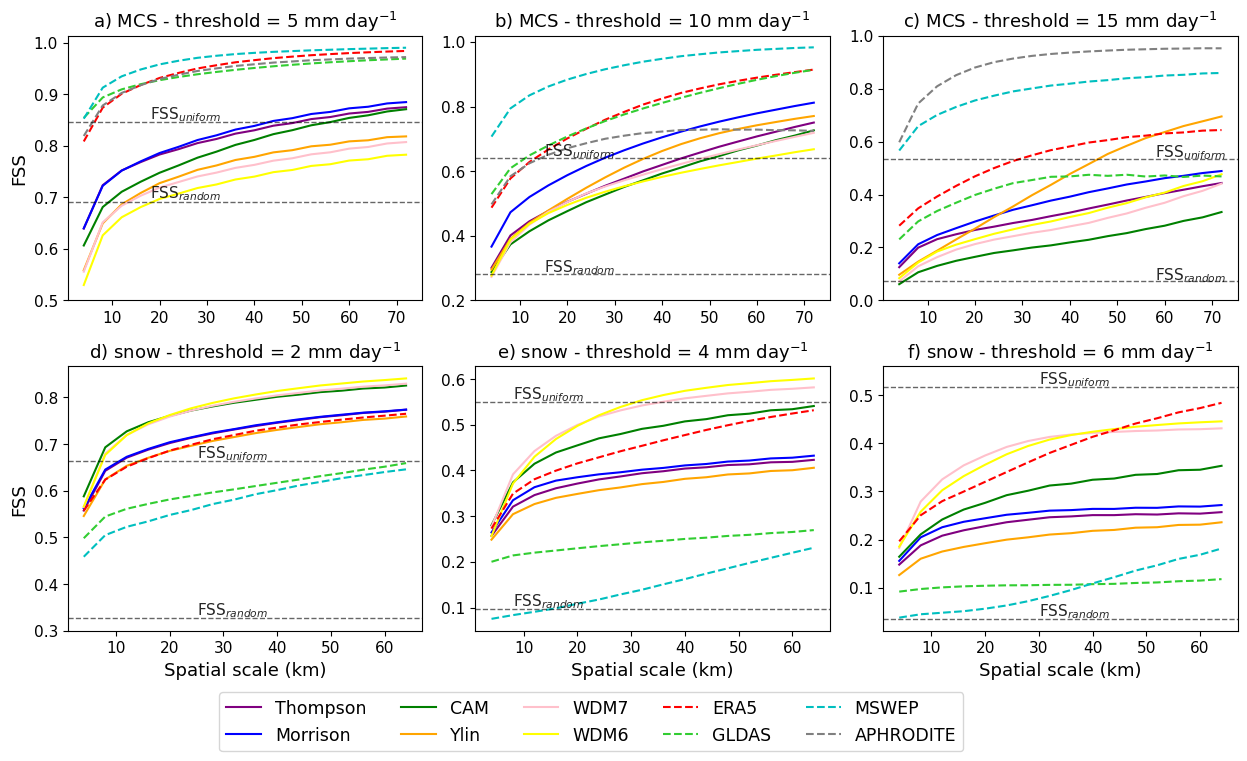

In [27]:
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 7))
axs = axs.flatten()

# Common plotting settings
models = ['Thompson', 'Morrison', 'CAM', 'Ylin', 'WDM7', 'WDM6']
colors = ['purple', 'blue', 'green', 'orange', 'pink', 'yellow']
obs_data = {
    'ERA5': ('r', 'dashed'),
    'GLDAS': ('limegreen', 'dashed'),
    'MSWEP': ('c', 'dashed'),
    'APHRODITE': ('grey', 'dashed')}

# Data and title configuration
plot_config = [
    # MCS thresholds
    (WRF_fss_mcs, ERA_fss_mcs, GLDAS_fss_mcs, MSWEP_fss_mcs, APHRO_fss_mcs, kernel, [5, 10, 15],
     [r'a) MCS - threshold = 5 mm day$^{-1}$',
      r'b) MCS - threshold = 10 mm day$^{-1}$',
      r'c) MCS - threshold = 15 mm day$^{-1}$'],
     FSSu_mcs, FSSr_mcs,
     [(18, 0.007), (15, 0.008), (58, 0.008)],
     [0, 1, 2],
     [(10, 20, 30, 40, 50, 60, 70), (0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
      (0.2, 0.4, 0.6, 0.8, 1.0),
      (0, 0.2, 0.4, 0.6, 0.8, 1.0)]),
    
    # Snow thresholds
    (WRF_fss_snow, ERA_fss_snow, GLDAS_fss_snow, MSWEP_fss_snow, None, skernels, [2, 4, 6],
     [r'd) snow - threshold = 2 mm day$^{-1}$',
      r'e) snow - threshold = 4 mm day$^{-1}$',
      r'f) snow - threshold = 6 mm day$^{-1}$'],
     FSSu_snow, FSSr_snow,
     [(25, 0.007), (8, 0.007), (30, 0.007)],
     [3, 4, 5],
     [None, (0.3, 0.4, 0.5, 0.6, 0.7, 0.8), None,
      (0, 0.1, 0.2, 0.3, 0.4, 0.5)])]

# Loop over both MCS and snow configs
for data in plot_config:
    wrf, era, gldas, mswep, aphro, k, thresholds, titles, fssu, fssr, text_pos, idxs, ticks = data
    for i, (thr, title, pos, idx) in enumerate(zip(thresholds, titles, text_pos, idxs)):
        ax = axs[idx]
        for model, color in zip(models, colors):
            ax.plot(k * 4, wrf[thr][model].flatten(), color=color, label=model)

        for obs_name, (color, style) in obs_data.items():
            obs_dict = {'ERA5': era, 'GLDAS': gldas, 'MSWEP': mswep, 'APHRODITE': aphro}
            if obs_dict[obs_name] is not None:
                ax.plot(k * 4, obs_dict[obs_name][thr].flatten(), color=color, linestyle=style, label=obs_name)

        ax.set_title(title, fontsize=13)
        if idx in [0, 3]:
            ax.set_ylabel('FSS', fontsize=13)
        if idx >= 3:
            ax.set_xlabel('Spatial scale (km)', fontsize=13)

        ax.axhline(y=fssu[i], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
        ax.axhline(y=fssr[i], color='k', linestyle='dashed', linewidth=1, alpha=0.6)

        ax.text(pos[0], fssu[i] + pos[1], r'FSS$_{uniform}$', color='k', alpha=0.85, fontsize=11)
        ax.text(pos[0], fssr[i] + pos[1], r'FSS$_{random}$', color='k', alpha=0.85, fontsize=11)

        ax.tick_params(axis='x', labelsize=11)
        ax.tick_params(axis='y', labelsize=11)

# Custom ticks
axs[0].set_xticks([10, 20, 30, 40, 50, 60, 70])
axs[1].set_xticks([10, 20, 30, 40, 50, 60, 70])
axs[2].set_xticks([10, 20, 30, 40, 50, 60, 70])
axs[0].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
axs[1].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
axs[2].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axs[3].set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
axs[5].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
axs[5].set_ylim([0.01, 0.56])

fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.15, hspace=0.25)
axs[0].legend(ncol=5, bbox_to_anchor=(2.55, -1.45), fontsize=12.5)

# Save the plot as a hd file
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/FSS.png', dpi=400, bbox_inches='tight')
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission_svg/FSS-svg.svg', format='svg', dpi=400, bbox_inches='tight')